#### Classification Example:  Predict Review Score Based on Its Text

* Get a sample of reviews from our Amazon data set
* How accurately can we classify a new review based on fields different from its score?

First re-cast the problem
* Original problem is a regression problem -- predict score value
* This often does not work in practice, the difference between 2 and 3, and 3 and 4 often cannot be predicted from the review summary and body.

Quantize the problem
* Score of 1 and 2 are "bad" reviews
* Score f 4 and 5 are "good" reviews
* Problem becomes a classification problem

----------------------------------------------------

**First steps**

* Gather a set of training examples
* Reformat them to make them ready to use with a learning algorithm

The file "reviews.txt" was just sampled from the reviews collection, 
from reviews with scores of 1,2,4, and 5. The sampling tried to get approx 1000 positive and 1000 
negative training examples.   

The full set isn't really equally balanced -- in the full set, positive is about 5 to 1 over negative -- and dealing with imbalanced classes is a real issue, but we will ignore class imbalance for this exercise.

In [ ]:
import numpy as np
import pandas as pd

In [23]:
def load_training(filename="reviews.txt"):
    training = []
    for line in open(filename):
        training.append(eval('(' + line + ')'))
    return training

In [201]:
raw_training = load_training()


2973


In [48]:
reviews = pd.DataFrame.from_records(raw_training)

In [27]:
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A007549913T3THC2E44K5,B0046ZHQAW,Marce,"[3, 4]","is a very good iron, your hair look beautiful ...",5.0,Really good one,1366329600,"04 19, 2013"
1,A03666331WS5WUZMM0AUD,B00007M0CP,Susanne Gonzalez Delgado,"[3, 3]",Good quality for this Price. The curls gets qu...,5.0,Conair Xtreme Instant Heat Multisized Hot Roll...,1378080000,"09 2, 2013"
2,A03898972RKS9HXS4H1F3,B002610SB2,Nancy Denise Graves,"[4, 5]",The shirt fits perfectly--true to size. It is...,5.0,It was exactly what I was looking for!,1358726400,"01 21, 2013"
3,A04051149NH0IDZZ4FH7,B002610SB2,Donnie,"[4, 4]","Wife hates hot days, well we live in florida.....",5.0,Nice shirt for the wife,1394755200,"03 14, 2014"
4,A06263011FDVMGFVAALWO,B00007M0CP,Hannah Moss,"[0, 0]",So much faster for me than using a curling iro...,5.0,I love them!,1365984000,"04 15, 2013"


In [49]:
asins = reviews.asin

In [50]:
reviews.drop(['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [30]:
reviews.head()

,reviewText,overall,summary
0,"is a very good iron, your hair look beautiful ...",5.0,Really good one
1,Good quality for this Price. The curls gets qu...,5.0,Conair Xtreme Instant Heat Multisized Hot Roll...
2,The shirt fits perfectly--true to size. It is...,5.0,It was exactly what I was looking for!
3,"Wife hates hot days, well we live in florida.....",5.0,Nice shirt for the wife
4,So much faster for me than using a curling iro...,5.0,I love them!


In [31]:
reviews.overall.value_counts()

5.0    1712
4.0     604
3.0     286
1.0     228
2.0     143
Name: overall, dtype: int64

What fields should be our independent (X) variables?  
Convert data frame:  include only desired X variables, and code the y variable

In [51]:
reviews = reviews[reviews.overall != 3]

In [216]:
raw_training = np.delete(raw_training, list(map(lambda j: j['overall'] == 3.0, raw_training)))

In [52]:
reviews.overall.value_counts()

5.0    1712
4.0     604
1.0     228
2.0     143
Name: overall, dtype: int64

In [53]:
y = list(map(lambda s: 0 if s < 3 else 1, reviews.overall))

In [54]:
reviews.drop(['overall'], axis=1, inplace=True)

In [55]:
reviews.shape

(2687, 3)

In [56]:
reviews.head()

,helpful,reviewText,summary
0,"[3, 4]","is a very good iron, your hair look beautiful ...",Really good one
1,"[3, 3]",Good quality for this Price. The curls gets qu...,Conair Xtreme Instant Heat Multisized Hot Roll...
2,"[4, 5]",The shirt fits perfectly--true to size. It is...,It was exactly what I was looking for!
3,"[4, 4]","Wife hates hot days, well we live in florida.....",Nice shirt for the wife
4,"[0, 0]",So much faster for me than using a curling iro...,I love them!


In [57]:
reviews['text'] = reviews.reviewText + reviews.summary

In [58]:
reviews.head()

,helpful,reviewText,summary,text
0,"[3, 4]","is a very good iron, your hair look beautiful ...",Really good one,"is a very good iron, your hair look beautiful ..."
1,"[3, 3]",Good quality for this Price. The curls gets qu...,Conair Xtreme Instant Heat Multisized Hot Roll...,Good quality for this Price. The curls gets qu...
2,"[4, 5]",The shirt fits perfectly--true to size. It is...,It was exactly what I was looking for!,The shirt fits perfectly--true to size. It is...
3,"[4, 4]","Wife hates hot days, well we live in florida.....",Nice shirt for the wife,"Wife hates hot days, well we live in florida....."
4,"[0, 0]",So much faster for me than using a curling iro...,I love them!,So much faster for me than using a curling iro...


In [64]:
print(reviews.shape)
print(len(y))

(2687, 4)
2687


Now we have a text field as our X, and we have to convert it to a real input vector.
First look at CountVectorizer:  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


In [80]:
from sklearn.feature_extraction.text import CountVectorizer
#v = CountVectorizer(min_df=2)
v = CountVectorizer(max_df=.75)
X = v.fit_transform(reviews.text)

Side step:  look at excluding very rare terms (min_df) and very common terms (max_df)

In [81]:
v.vocabulary_

{'is': 7355,
 'very': 14697,
 'good': 6045,
 'iron': 7340,
 'your': 15318,
 'hair': 6283,
 'look': 8150,
 'beautiful': 1510,
 'in': 6970,
 'just': 7557,
 'one': 9456,
 'pass': 9806,
 'does': 4240,
 'not': 9252,
 'hurt': 6807,
 'it': 7377,
 'all': 747,
 'can': 2235,
 'sayreally': 11830,
 'quality': 10774,
 'for': 5571,
 'this': 13791,
 'price': 10470,
 'curls': 3533,
 'gets': 5922,
 'quite': 10815,
 'tight': 13870,
 'if': 6870,
 'you': 15309,
 'have': 6412,
 'eacute': 4469,
 'dium': 4197,
 'long': 8140,
 'now': 9287,
 'longer': 8141,
 'results': 11394,
 'looks': 8155,
 'better': 1626,
 'as': 1109,
 'more': 8863,
 'natural': 9054,
 'only': 9471,
 'thing': 13775,
 'dislike': 4151,
 'that': 13721,
 'my': 8988,
 'fingers': 5378,
 'get': 5918,
 'constantly': 3139,
 'burned': 2124,
 'guess': 6225,
 'am': 802,
 'at': 1168,
 'but': 2147,
 'would': 15220,
 'be': 1480,
 'gread': 6144,
 'came': 2215,
 'with': 15134,
 'special': 12764,
 'glove': 6009,
 'to': 13920,
 'avoid': 1271,
 'top': 13972,
 '

In [82]:
v.stop_words_

{'and', 'the'}

In [83]:
print(X.shape)
print(len(y))

(2687, 15368)
2687


**Our Input Data**
1. The X matrix
2. The vectorizer
3. The y vector

Simple NB classifier for binary response variable -- the [documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) is good -- be sure to read it! 

In [84]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb.fit(X,y)

BernoulliNB()

In [85]:
# Use the model to predict the value of all records in the training set
ypred = nb.predict(X)
print(len(ypred))
print(ypred)

2687
[1 1 1 ... 1 1 1]


In [87]:
# How many "good" predicitions are they, and how does that compare to actual y values?
from collections import Counter
print(Counter(ypred))
print(Counter(y))

Counter({1: 2492, 0: 195})
Counter({1: 2316, 0: 371})


Various tools to measure prediction accuracy

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Confusion matrix -- argument order matters -- y is 
# down the rows because it is first.  Predicted is across the 
# columns because it is second.

print(confusion_matrix(y, nb.predict(X)))
print(accuracy_score(y, nb.predict(X)))

# Remember, this is training accuracy.  Bad if it's low, meaningless if it's high

[[ 101  270]
 [  94 2222]]
0.8645329363602531


In [92]:
# Quick way to split our X and y into training and test pieces for measuring
# test accuracy

# The random_state argument seeds the random number generator so you get the
# same split each time.  Not random, but good for debugging

from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [93]:
# Just a method so we can evaluate a classifier easily

def eval_test_set(clf, xtrain, ytrain, xtest, ytest):
    clf.fit(xtrain, ytrain)
    print(confusion_matrix(ytest, clf.predict(xtest)))
    print(accuracy_score(ytest, clf.predict(xtest)))

In [94]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
eval_test_set(BernoulliNB(), xTrain, yTrain, xTest, yTest)
eval_test_set(MultinomialNB(), xTrain, yTrain, xTest, yTest)

#  Too bad, test accuracy is much worse than training accuracy

[[ 11  85]
 [ 53 523]]
0.7946428571428571
[[ 24  72]
 [ 17 559]]
0.8675595238095238


**Cross-Fold Validation**

In [95]:
# Cross-fold validation -- this is 10-fold, split the X and y into 
# ten pieces, loop ten times, one for each piece:  train on the other 9, 
# then test on the 10th.   Average is estimate for test accuracy

from sklearn.model_selection import cross_val_score
def cross_validate(clf, x, y):
    return cross_val_score(clf, x, y, cv=10).mean()

In [121]:
def eval_classifier(clf, X, y):
    clf.fit(X,y)
    print(f"Results for {clf}")
    print(f"Cross validation mean accuracy: {cross_validate(clf, X, y)}")
    print(f"Training accuracy: {accuracy_score(y, clf.predict(X))}")
    print(confusion_matrix(y, clf.predict(X)))


In [111]:
from sklearn.naive_bayes import ComplementNB
print(cross_validate(BernoulliNB(), X, y))
print(cross_validate(MultinomialNB(), X, y))
print(cross_validate(ComplementNB(), X, y))

# This should be a little better than the holdback test accuracy
# because we get to use all the test data

# This is our baseline accuracy -- can we change preprocessing and/or get 
# rid of features to improve it?

0.8191116906175442
0.8801545247739
0.8753190367863286


In [123]:
eval_classifier(BernoulliNB(), X, y)
print()
eval_classifier(MultinomialNB(), X, y)
print()
eval_classifier(ComplementNB(), X, y)


Results for BernoulliNB()
Cross validation mean accuracy: 0.8191116906175442
Training accuracy: 0.8645329363602531
[[ 101  270]
 [  94 2222]]

Results for MultinomialNB()
Cross validation mean accuracy: 0.8801545247739
Training accuracy: 0.9594343133606252
[[ 279   92]
 [  17 2299]]

Results for ComplementNB()
Cross validation mean accuracy: 0.8753190367863286
Training accuracy: 0.9616672869371046
[[ 308   63]
 [  40 2276]]


**Other Options for a Classifier**

How do these perform compared to our Naive Bayes baseline?

1. Rocchio (nearest centroid)
2. Nearest neighbor

In [125]:
from sklearn.neighbors import NearestCentroid
eval_classifier(NearestCentroid(), X,y)

Results for NearestCentroid()
Cross validation mean accuracy: 0.7703670310159241
Training accuracy: 0.7912169705991813
[[ 224  147]
 [ 414 1902]]


In [126]:
from sklearn.neighbors import KNeighborsClassifier
eval_test_set(KNeighborsClassifier(n_neighbors=20), X,y)

0.8626726959995562
[[   3  368]
 [   0 2316]]
0.8630442873092669


In [127]:
# Here is apples-to-apples comparison of all models we have tried so far

print(f"Bernoulli Naive Bayes {cross_validate(BernoulliNB(), X, y)}")
print(f"Multinomial Naive Bayes {cross_validate(MultinomialNB(), X, y)}")
print(f"Complement Naive Bayes {cross_validate(ComplementNB(), X, y)}")
print(f"Nearest Centroid {cross_validate(NearestCentroid(), X,y)}")
print(f"Nearest neighbors (20) {cross_validate(KNeighborsClassifier(n_neighbors=20), X, y)}")
print(f"Nearest neighbors (5) {cross_validate(KNeighborsClassifier(n_neighbors=5), X, y)}")
print(f"Nearest neighbors (12) {cross_validate(KNeighborsClassifier(n_neighbors=12), X, y)}")

Bernoulli Naive Bayes 0.8191116906175442
Multinomial Naive Bayes 0.8801545247739
Complement Naive Bayes 0.8753190367863286
Nearest Centroid 0.7703670310159241
Nearest neighbors (20) 0.8626726959995562
Nearest neighbors (5) 0.8634189646562727
Nearest neighbors (12) 0.864532819175498


Tentative decision:  choose Multinomial Naive Bayes, reject Rocchio, and experiment to see how much we can improve KNN

**Hyperparameter Optimization**

Nearest Neighbor is the only algorithm with a hyperparameter (number of neighbors)

In [128]:
from sklearn.model_selection import GridSearchCV

# Loop over number of neighbors, and compute cross-validated accuracy for each setting.
# Remember the parameter setting with the best accuracy.
# Notice that the result of GridSearchCV is also a classifier -- it has fit and predict methods

clf = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': range(1,50,2)}, cv=10, scoring='accuracy')
clf.fit(X, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 50, 2)}, scoring='accuracy')

In [129]:
# Notice that the grid search is actually a classifier too!
clf.best_estimator_

KNeighborsClassifier(n_neighbors=7)

In [130]:
clf.cv_results_

{'mean_fit_time': array([0.00329578, 0.00300138, 0.0030009 , 0.00299962, 0.00299628,
        0.00279992, 0.00299091, 0.00280063, 0.00260286, 0.00280509,
        0.00260177, 0.00299494, 0.00279799, 0.00289862, 0.00249946,
        0.00289602, 0.00290368, 0.0026973 , 0.00269883, 0.00249856,
        0.00289543, 0.00289505, 0.0027986 , 0.00298822, 0.00290251]),
 'std_fit_time': array([6.43995665e-04, 4.55311976e-04, 6.31846580e-04, 2.96455072e-06,
        1.09791950e-05, 3.91409960e-04, 4.38450429e-04, 4.01408873e-04,
        4.94851471e-04, 4.02641734e-04, 4.83352439e-04, 1.15916799e-05,
        3.98923377e-04, 2.99287272e-04, 5.00040570e-04, 2.99403614e-04,
        3.01467890e-04, 4.56192816e-04, 4.49022048e-04, 4.98944674e-04,
        5.36799535e-04, 5.31200447e-04, 3.99294960e-04, 4.40899315e-04,
        3.01209375e-04]),
 'mean_score_time': array([0.04321139, 0.04269962, 0.04611547, 0.04379902, 0.04471042,
        0.04399917, 0.04360812, 0.04421372, 0.04439709, 0.04409671,
        0.04

In [131]:
# Just for completeness, this is optimal accuracy for KNN.
print(f"Nearest neighbors (optimal) {cross_validate(clf, X, y)}")

Nearest neighbors (5) 0.8649059535038562


In [134]:
#  There is an interesting curve relating number of neighbors to accuracy
#  This piece just collects (x,y) pairs where x is neighbors and y is accuracy,
#   so we can do a plot

neighbors = []
accuracies = []

for nn in range(1,100,2):
    neighbors.append(nn)
    accuracies.append(cross_validate(KNeighborsClassifier(n_neighbors=nn), X, y))

Text(0, 0.5, 'Accuracy')

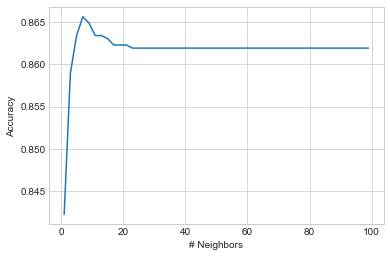

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt

# (x,y) line plot of number of neighbors vs test accuracy
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.axes()
ax.plot(neighbors, accuracies);
ax.set_xlabel('# Neighbors')
ax.set_ylabel("Accuracy")

In [139]:
# What value is the accuracy converging to?
Counter(y)[1]/ (Counter(y)[0]+Counter(y)[1])

0.8619278005210271

----------------------------------------------
### Feature Engineering

Improve the algorithm by modifying the vectorizer, limiting features

This all starts with the assumption that we will go with Naive Bayes as our classifier of choice

1.  See if we can improve the tokenizer -- TFIDF
  1. We could try n-grams and stop words too, because the Vectorizer can do those for us
2.  See if we can limit features -- do it in the Vectorizer, and also try some more informed greedy methods like mutual information
3.  Examine the misclassifications to see if there's anything obviously wrong

* Variations on the vectorizer -- try just Count vs Tfidf
* Other variants would be stemming, n-grams, stop words 

In [142]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

b = MultinomialNB()

v = CountVectorizer()
X = v.fit_transform(reviews.text)
print(f"Count Vectorizer {cross_validate(b, X, y)}")

v = TfidfVectorizer()
X = v.fit_transform(reviews.text)
print(f"Tfidf Vectorizer {cross_validate(b, X, y)}")


Count Vectorizer 0.8797841646784663
Tfidf Vectorizer 0.8615560672474061


In [144]:
# Try restricting out uncommon and super common words
v = CountVectorizer(min_df=2, max_df=.95)
X = v.fit_transform(reviews.text)
print(f"Count Vectorizer {cross_validate(b, X, y)}")

Count Vectorizer 0.8812780891083614


In [145]:
# Try bigrams
v = CountVectorizer(min_df=2, max_df=.95, ngram_range=(1,2))
X = v.fit_transform(reviews.text)
print(f"Count Vectorizer {cross_validate(b, X, y)}")

Count Vectorizer 0.9017560894412695


In [146]:
X.shape

(2687, 27938)

### Feature Selection by Mutual Information


#### Feature selection by mutual information measure

In [147]:
from sklearn.feature_selection import mutual_info_classif
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
mutual_info_classif(X,y)

array([0.00031059, 0.00022137, 0.00011064, ..., 0.00038763, 0.00011064,
       0.00011064])

In [154]:
# Select K best
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
from sklearn.feature_selection import SelectKBest
newX = SelectKBest(mutual_info_classif, k=100).fit_transform(X,y)
newX.shape

(2687, 100)

In [156]:
def k_features_x(k, X, y, fs=mutual_info_classif):
    kbest = SelectKBest(fs, k=k)
    return kbest.fit_transform(X, y)

#  Assess accuracy of the classifier after choosing k best features
def k_features_accuracy(k, clf, x, y, fs=mutual_info_classif):
    X_new = k_features_x(k, x, y, fs)
    return cross_validate(clf, X_new, y)


In [158]:
X = CountVectorizer(min_df=2, max_df=.95, ngram_range=(1,2)).fit_transform(reviews.text)
k_features_accuracy(5000, MultinomialNB(), X, y)

0.9419533374022082

In [160]:
###########################
# Caution!!  This takes a very long time!

mnb = MultinomialNB()
v = CountVectorizer(min_df=2, max_df=.95, ngram_range=(1,2))
X = v.fit_transform(reviews.text)

#  Set up to plot accuracy as a function of k (number features)
xval = []
yval = []
for k in range(100, 4000, 400):
    print(k)
    xval.append(k)
    yval.append(k_features_accuracy(k, mnb, X, y))
for k in range(4000, X.shape[1], 500):
    print(k)
    xval.append(k)
    yval.append(k_features_accuracy(k, mnb, X, y))

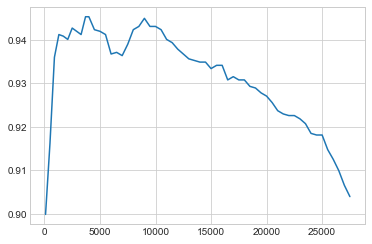

In [161]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
fig = plt.figure()
ax = plt.axes()
ax.plot(xval, yval);

# Nice plot with optimal number of features around 3000 (out of 14.8K!)

Sample plot of cross-val accuracy vs number of features

![Accuracy vs num features](accuracy_vs_num_features.png)

### Classifier-Specific Feature Impact

Since we are using Naive Bayes, the classifier itself has a measure of feature impact, through the ratio of P(term|class=0) / P(term|class=1).

In that ratio, the highest value are the terms that are "most negative" and the lowest values are the terms that are "most positive" and a value of 1 means the term is irrelevant.   

This code shows the features that have the highest and lowest ratio.

The question is whether this measure is better than mutual information for limiting # features

In [168]:
v = CountVectorizer(min_df=2, max_df=.95)
X = v.fit_transform(reviews.text)
b = MultinomialNB()
b.fit(X, y)

#v.get_feature_names()
b.feature_log_prob_

array([[ -9.10841838, -10.49471274,  -9.39610045, ..., -10.49471274,
        -10.49471274, -10.49471274],
       [ -9.68440959, -10.29054539, -11.38915768, ..., -10.47286695,
        -10.98369257,  -9.30971614]])

In [169]:
def log_prob_ratios(classifier):
    return classifier.feature_log_prob_[0] / classifier.feature_log_prob_[1]

In [173]:
sorted(list(log_prob_ratios(b)), reverse=True)[0:10]

[1.3820346192536608,
 1.3743822770074574,
 1.3585415756550019,
 1.3445040295876998,
 1.3420992392390403,
 1.3342531418730963,
 1.3256840649867863,
 1.3126229923130972,
 1.3012509898392406,
 1.2966869892539765]

In [174]:
def important_features(vectorizer,classifier,n=20):
    feature_names =vectorizer.get_feature_names()
    log_prob_frac = log_prob_ratios(classifier)
    frac_and_name_pos = sorted(zip(log_prob_frac, feature_names),reverse=True)[:n]
    frac_and_name_neg = sorted(zip(log_prob_frac, feature_names),reverse=False)[:n]   
    print(f"Important words POSITIVE")
    for coef, feat in frac_and_name_pos:
        print(coef, feat)
    print("==========")
    print(f"Important words NEGATIVE")
    for coef, feat in frac_and_name_neg:
        print(coef, feat)


In [176]:
v = CountVectorizer(min_df=2, max_df=.95)
X = v.fit_transform(reviews.text)
b = MultinomialNB()
b.fit(X, y)
important_features(v, b, n=20)

Important words POSITIVE
1.3820346192536608 enjoyed
1.3743822770074574 love
1.3585415756550019 season
1.3445040295876998 stories
1.3420992392390403 drama
1.3342531418730963 nypd
1.3256840649867863 life
1.3126229923130972 series
1.3012509898392406 great
1.2966869892539765 her
1.294543525403217 war
1.291783898436456 perfect
1.2895192470320413 highly
1.2876191016779237 girl
1.2876191016779237 cop
1.2835973219904377 interesting
1.282985599741782 loves
1.2781122896220751 seasons
1.2748435691416997 franz
1.274646736041206 show
Important words NEGATIVE
0.6701384845929526 sizing
0.6964955195094952 leaking
0.7032834488432729 refund
0.7075473340556688 griddle
0.7075473340556688 valves
0.7109232918785363 defective
0.7139240736303036 waste
0.7192917930856206 knob
0.7203057176247516 email
0.7203057176247516 melted
0.7203057176247516 refunded
0.721957878282555 disappointing
0.7234544723499297 flame
0.7344472420956532 useless
0.7353956825674703 advertising
0.7353956825674703 august
0.7353956825674703

The SelectKBest feature selector can take a ranking function as an input -- previously we used the built-in ranker mutual information, but we can use the probability ratio instead.  In this case a feature is more significant the farther away from 1 it is.

In [180]:
# Signature is dictated by SelectKBest -- 
#  "Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores"

# Returns a vector of scores for each feature based on the score ratio
def prob_ratio_score(X, y):
    b = MultinomialNB()
    b.fit(X, y)
    log_prob_frac = log_prob_ratios(b)
    return abs(log_prob_frac - 1.0)

In [181]:
#  Now we can select the K best features based on the ratio.  Just for a reality check:  
#  this transform should reduce the number of features from 14.8K to 2K
v = CountVectorizer(min_df=2, max_df=.95)
X = v.fit_transform(reviews.text)
kbest = SelectKBest(prob_ratio_score, k=2000)
XX = kbest.fit_transform(X, y)
print(X.shape)
print(XX.shape)

(2687, 7230)
(2687, 2000)


In [182]:
# And here is our head-to-head comparison.  Same classifier, same vectorizer, same 
#  number of features, but we just rank the features differently
v = CountVectorizer(min_df=2, max_df=.95)

print(k_features_accuracy(3000, MultinomialNB(), v.fit_transform(reviews.text), y))
print(k_features_accuracy(3000, MultinomialNB(), v.fit_transform(reviews.text), y, prob_ratio_score))


0.9065860289629919
0.9177509293680297


-------------------------------------------------------

### Examining Misclassified Instances

1. Find some misclassified instances
2. Visually, can we see anything that would make us worry or not worry?
3. If the reason for misclassification isn't obvious, look more closely at the words and their scores according to the classifier

In [184]:

# This is our baseline best classifier.
b = MultinomialNB()
v = CountVectorizer(min_df=2, max_df=.95)
X = v.fit_transform(reviews.text)
kbest = SelectKBest(prob_ratio_score, k=3000)
X = kbest.fit_transform(X, y)
eval_test_set(b, Xnew, y)


0.9177509293680297
[[ 330   41]
 [  83 2233]]
0.9538518794194268


In [186]:
#  Get indices of some misclassified instances.  Remember that
#  the index (observation #) is the same in X, y
b.fit(X, y)
pred = b.predict(X)
mask = pred != np.array(y)
misclassed = np.array(list(zip(range(0,len(pred)), zip(y, pred))), dtype=object)
misclassed[mask]

# For example [167, (1, 0)] means that for example # 167, the actual value was 1 but we predicted 0

array([[45, (1, 0)],
       [54, (1, 0)],
       [104, (1, 0)],
       [121, (1, 0)],
       [129, (1, 0)],
       [160, (1, 0)],
       [165, (1, 0)],
       [188, (1, 0)],
       [215, (0, 1)],
       [218, (0, 1)],
       [227, (1, 0)],
       [303, (1, 0)],
       [309, (1, 0)],
       [314, (1, 0)],
       [353, (0, 1)],
       [354, (1, 0)],
       [358, (1, 0)],
       [407, (1, 0)],
       [411, (1, 0)],
       [414, (1, 0)],
       [421, (1, 0)],
       [433, (0, 1)],
       [443, (0, 1)],
       [453, (0, 1)],
       [464, (1, 0)],
       [514, (1, 0)],
       [516, (0, 1)],
       [547, (1, 0)],
       [548, (0, 1)],
       [566, (1, 0)],
       [595, (0, 1)],
       [623, (1, 0)],
       [625, (1, 0)],
       [663, (0, 1)],
       [670, (1, 0)],
       [685, (0, 1)],
       [709, (0, 1)],
       [730, (1, 0)],
       [765, (1, 0)],
       [817, (0, 1)],
       [827, (0, 1)],
       [846, (1, 0)],
       [866, (0, 1)],
       [899, (1, 0)],
       [925, (1, 0)],
       [926,

In [219]:
# Actual label is good (1), we classify bad (0)
raw_training[45]

{'reviewerID': 'A10MVE2MEOU6XT',
 'asin': 'B002YLEPP4',
 'reviewerName': 'Julie Schmidt',
 'helpful': [7, 7],
 'reviewText': 'I love popcorn seasoning, but they all mostly taste like salt.  This one tastes like white cheddar!  Imagine that.  I will never order the other kind again.',
 'overall': 5.0,
 'summary': 'Finally tastes like Cheese and not Salt!',
 'unixReviewTime': 1297728000,
 'reviewTime': '02 15, 2011'}

In [220]:
b.predict_proba(X)[45]

array([0.9931769, 0.0068231])

In [222]:
kbest.get_support()

array([ True, False,  True, ..., False, False,  True])

In [189]:
#  Get the fitted classifier's term probabilities -- i.e the ratio P(term|class=0) / P(term|class=1)
#  Remember that the classifier is working on a reduced set of features!
#  The vectorizer knows the term names, but it stores the larger set of features so we have to 
def feature_log_prob(b, v, k):
    # Select the feature names actually used by kbest
    feature_names = np.array(v.get_feature_names())[k.get_support()]
    log_prob_frac = b.feature_log_prob_[0] / b.feature_log_prob_[1]
    return dict(zip(feature_names, log_prob_frac))

In [190]:
#  Show the log prob ratio for the instance with this index.
#  NOTE -- this is using values of b (classifier), v(vectorizer), and kbest(X with reduced features)

def show_scores_for(index, b, v, k):
    # Mapping of term to log prob (all possible features)
    flp = feature_log_prob(b,v,k)
    # Feature names, only the k best
    feature_names = np.array(v.get_feature_names())[k.get_support()]
    # Term values (just a count) 
    termvals = X[index].toarray().ravel()
    scores = []
    for i in range(0, termvals.shape[0]):
        if termvals[i] > 0:
            scores.append((feature_names[i], termvals[i], flp[feature_names[i]]))
    return sorted(scores, key=lambda x: x[2])

In [221]:
show_scores_for(45, b, v, kbest)
# These are the term scores for the short review

[('cheddar', 1, 0.7654402763756577),
 ('popcorn', 1, 0.8183403641569169),
 ('not', 1, 0.86830103806625),
 ('salt', 2, 0.8692725476680273),
 ('seasoning', 1, 0.8843338888106116),
 ('white', 1, 0.9025628768237343),
 ('cheese', 1, 0.9096996960582528),
 ('never', 1, 0.9395533152410037),
 ('finally', 1, 0.9426429080654279),
 ('this', 1, 1.0829906343584939),
 ('and', 1, 1.1305001378416628),
 ('mostly', 1, 1.2033999126536807),
 ('love', 1, 1.4220501766557792)]

In [225]:
# This is a misprediction where label is bad but we predicted good
b.predict_proba(Xnew)[817]

array([0.26126554, 0.73873446])

In [228]:
raw_training[817]

{'reviewerID': 'A1DZT5D7BNDY5H',
 'asin': '1580626513',
 'reviewerName': 'Teacher Jan',
 'helpful': [4, 7],
 'reviewText': "This is not going to help you learn to play.  It is filled with a lot of useless information.  Don't buy it, unless you just want to read about playing the piano or keyboard.",
 'overall': 1.0,
 'summary': 'Useless book',
 'unixReviewTime': 1142726400,
 'reviewTime': '03 19, 2006'}

In [226]:
show_scores_for(817, b, v, kbest)

[('useless', 2, 0.7156815258710432),
 ('not', 1, 0.86830103806625),
 ('unless', 1, 0.8707862888834099),
 ('keyboard', 1, 0.9096996960582528),
 ('don', 1, 0.9327382252209842),
 ('play', 1, 1.0525643072983926),
 ('with', 1, 1.0562614222870694),
 ('is', 2, 1.058512107946147),
 ('playing', 1, 1.0656065366015852),
 ('to', 3, 1.0729113494759033),
 ('you', 2, 1.0774858909505538),
 ('this', 1, 1.0829906343584939),
 ('learn', 1, 1.0838206109476933),
 ('piano', 1, 1.0898975237904718),
 ('of', 1, 1.0910289504160224),
 ('lot', 1, 1.154781756017009),
 ('read', 1, 1.180599373217057),
 ('book', 1, 1.2887365827535455)]